In [1]:
from pyspark.sql.functions import *       # added for the function 
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from operator import add


from datetime import datetime

spark = SparkSession.builder \
    .master('local') \
    .appName('distanceGroup') \
    .getOrCreate()

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step
    
# Functions to give groupNumber
def groupNumber(n):
    y = 0
    for x in my_range(0, 2600, 200):
        if(n < x):
            return y
        else:
            y += 1
    
allflights = spark.read.load("./data/alldata.csv",format="csv", sep=",", header="true")

df = allflights.select("Distance", "DepDelay", "ArrDelay")
df = df.withColumn("Distance", df["Distance"].cast(IntegerType()))
df = df.filter((df['Distance'] < 2600)) #The last group contains flights whose distances are between 2400 and 2599 miles
df = df.where(col("Distance").isNotNull() & col("DepDelay").isNotNull() & col("ArrDelay").isNotNull())

#df.show()

In [2]:
## Get the fligths in distance groups
GroupingAllFlights = df.rdd.map(lambda r: (groupNumber(r[0]),1)).reduceByKey(lambda x, y: x+y).toDF()
GroupingAllFlights = GroupingAllFlights.select(col("_1").alias("Group"), col("_2").alias("TotalCount"))
GroupingAllFlights = GroupingAllFlights.sort(col("Group").asc())
#GroupingAllFlights.show()

In [3]:
## Get the fligths which were able to halve their departure delay in distance groups
GroupingTresholdFlights = df.filter((df['DepDelay'] > 0)) #Only fligths with a departure delay are interesting
GroupingTresholdFlights = GroupingTresholdFlights.filter((df['ArrDelay'] <= df['DepDelay']/2))
GroupingTresholdFlights = GroupingTresholdFlights.rdd.map(lambda r: (groupNumber(r[0]),1)).reduceByKey(lambda x, y: x+y).toDF()
GroupingTresholdFlights = GroupingTresholdFlights.select(col("_1").alias("Groups"), col("_2").alias("Count"))
GroupingTresholdFlights = GroupingTresholdFlights.sort(col("Groups").asc())
#GroupingTresholdFlights.show()

In [4]:
## Join the two tables
Groups = GroupingAllFlights.join(GroupingTresholdFlights, GroupingTresholdFlights.Groups == GroupingAllFlights.Group, how='left').drop("Groups").na.fill(0)
Groups = Groups.withColumn("TotalCount", Groups["TotalCount"].cast(FloatType()))
Groups = Groups.withColumn("Count", Groups["Count"].cast(FloatType()))
Groups = Groups.sort(col("Group").asc())
#Groups.show()

In [10]:
## Calculate percentage for each group
GroupsWithPercentage = Groups.rdd.map(lambda r: (r[0], r[1], r[2], (r[2] / r[1])*100)).toDF()
GroupsWithPercentage = GroupsWithPercentage.select(col("_1").alias("Group"), col("_2").alias("TotalCount"), col("_3").alias("Count"), col("_4").alias("Percentage"))
#GroupsWithPercentage.show()

Text(0,0.5,'Percentage [%]')

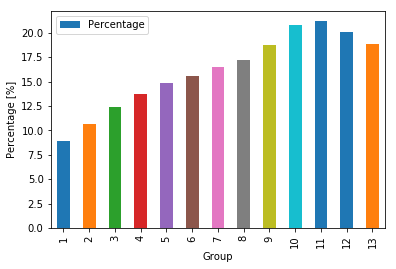

In [9]:
## Visualize the percentage for each group
import matplotlib
import matplotlib.pyplot as plt

Stats = GroupsWithPercentage.toPandas()

ax = Stats.head(13).plot.bar(x='Group', y='Percentage');

ax.set_xlabel("Group")
ax.set_ylabel("Percentage [%]")

In [7]:
## Statistics 
highest = Stats.loc[Stats['Percentage'].idxmax()] # Group with highest Percentage 
#print(highest)
lowest = Stats.loc[Stats['Percentage'].idxmin()]  # Group with lowest Percentage 
#print(lowest)

summary = GroupsWithPercentage.describe('Percentage')
print('\nGroup with highest Percentage : %i with %.2f%%' % (highest[0], highest[3]))
print('Group with lowest Percentage  : %i with %.2f%%\n' % (lowest[0], lowest[3]))
summary.show()



Group with highest Percentage : 11 with 21.22%
Group with lowest Percentage  : 1 with 8.96%

+-------+------------------+
|summary|        Percentage|
+-------+------------------+
|  count|                13|
|   mean|16.132185098890748|
| stddev| 3.888268037239493|
|    min| 8.959709054241833|
|    max| 21.21903476623132|
+-------+------------------+

